# Preperation

download covid19 data from Kaggle dataset：https://www.kaggle.com/kimjihoo/coronavirusdataset/download

In [1]:
# install modules
# https://causalinferenceinpython.org/
# !pip install causalgraphicalmodels
# https://pypi.org/project/CausalInference/
# !pip install causalinference
!pip install --upgrade pymc3
!pip install arviz
!pip install lifelines

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.9.3)


# import modules

In [2]:
import numpy as np
import pandas as pd
import random
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import stats
from statsmodels.duration.hazard_regression import PHReg
from IPython.display import display, Math, Latex, Markdown
# from causalgraphicalmodels import CausalGraphicalModel
# from causalinference import CausalModel
from theano import tensor as T
from matplotlib.pyplot import cm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get data

In [3]:
df_patient = pd.read_csv("PatientInfo.csv")
print (df_patient["patient_id"].count())
df_patient.head(5)

5165


,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df_patient[df_patient["state"]=="deceased"].sort_values("deceased_date").head(2)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
4902,6020100104,male,60s,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,NaN,NaN,NaN,2020-02-20,NaN,2020-02-19,deceased
4904,6020100205,female,50s,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,NaN,NaN,NaN,2020-02-22,NaN,2020-02-21,deceased


In [5]:
print (df_patient["sex"].value_counts())

female    2218
male      1825
Name: sex, dtype: int64


In [6]:
print (df_patient["country"].unique())

['Korea' 'China' 'United States' 'France' 'Thailand' 'Canada' 'India'
 'Switzerland' 'Germany' 'Indonesia' 'Vietnam' 'Foreign' 'Mongolia'
 'United Kingdom' 'Spain' 'Bangladesh']


In [7]:
df_patient[df_patient["state"]=="deceased"].count()

patient_id            78
sex                   75
age                   75
country               78
province              78
city                  59
infection_case        36
infected_by            3
contact_number         7
symptom_onset_date     6
confirmed_date        78
released_date          3
deceased_date         66
state                 78
dtype: int64

In [8]:
df_patient[df_patient["state"]=="isolated"].count()

patient_id            2158
sex                   1454
age                   1212
country               2158
province              2158
city                  2113
infection_case        1958
infected_by            869
contact_number         241
symptom_onset_date     279
confirmed_date        2158
released_date            5
deceased_date            0
state                 2158
dtype: int64

In [9]:
def process_data(df_patient):
    df = df_patient.copy()
    df = df[["sex","age",#"country",
            "confirmed_date","released_date","deceased_date","state"]]
    df["released_date"] = df["released_date"].astype("datetime64[ns]")
    df["confirmed_date"] = df["confirmed_date"].astype("datetime64[ns]")
    df["deceased_date"] = df["deceased_date"].astype("datetime64[ns]")

    # calculate time 
    df.loc[df["released_date"].notnull(), "timeline"] = df["released_date"] - df["confirmed_date"]
    df.loc[(df["state"]=="deceased") & (df["deceased_date"].notnull()), "timeline"] = df["deceased_date"] - df["confirmed_date"]
    df["timeline"] = pd.to_numeric(df['timeline'].dt.days, downcast='integer')
    print ("time min:{}, max:{}".format(df["timeline"].min(), df["timeline"].max()))
    
    # duration has to be non-negative number
    df = df.drop(df[df["timeline"]<0].index)

    # censoring
    df["event"] = np.where(df["state"]=="isolated", 0, 1)
    # deceased
    df["death"] = np.where(df["state"]=="deceased", 1, 0)

    # manage null data
    # random_int = np.random.randint(0, df["timeline"].max(), size = (df.shape[0], 1)) 
    # df["random_int"] = random_int
    # df.loc[df["timeline"].isnull(), "timeline"] = df["random_int"]
    # df = df.drop(["random_int"], axis=1)
    df = df.dropna(subset=["timeline"])
    # df.loc[df["timeline"].isnull(), "timeline"] = df["timeline"].max()

    df.reset_index(inplace=True)
    df.head(2)
    return df

df = process_data(df_patient)

time min:-1.0, max:114.0


In [10]:
df["state"].value_counts()

released    1579
deceased      65
isolated       5
Name: state, dtype: int64

In [11]:
df[df["event"]==0].head()

,index,sex,age,confirmed_date,released_date,deceased_date,state,timeline,event,death
97,1620,female,40s,2020-03-31,2020-04-13,NaT,isolated,13.0,0,0
99,1622,female,10s,2020-03-31,2020-04-13,NaT,isolated,13.0,0,0
101,1627,male,20s,2020-04-14,2020-04-22,NaT,isolated,8.0,0,0
176,1717,female,0s,2020-04-01,2020-05-12,NaT,isolated,41.0,0,0
804,3886,female,70s,2020-02-29,2020-04-01,NaT,isolated,32.0,0,0


In [12]:
df[df["state"] == "isolated"].sort_values("released_date", ascending=False).head(2)

,index,sex,age,confirmed_date,released_date,deceased_date,state,timeline,event,death
176,1717,female,0s,2020-04-01,2020-05-12,NaT,isolated,41.0,0,0
101,1627,male,20s,2020-04-14,2020-04-22,NaT,isolated,8.0,0,0


In [13]:
df[df["state"] == "deceased"].sort_values("released_date", ascending=False).head(2)

,index,sex,age,confirmed_date,released_date,deceased_date,state,timeline,event,death
1024,4106,female,70s,2020-03-05,2020-05-08,2020-05-11,deceased,67.0,1,1
898,3980,female,80s,2020-03-02,2020-03-30,2020-04-08,deceased,37.0,1,1


## Data visualisation

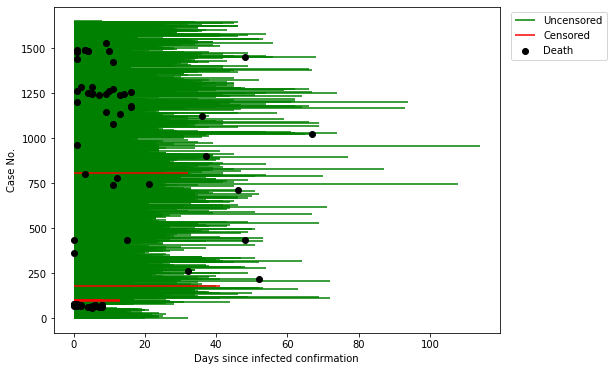

In [14]:
n_patients = df.shape[0]
patients = np.arange(n_patients)
fig, ax = plt.subplots(figsize=(8, 6))
blue, _, red = sns.color_palette()[:3]
ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].timeline, color='green', label='Uncensored')
ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].timeline, color='red', label='Censored')
ax.scatter(df[df.death.values == 1].timeline, patients[df.death.values == 1], color='k', zorder=10, label='Death')
ax.set_xlabel('Days since infected confirmation')
ax.set_ylabel('Case No.')
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))

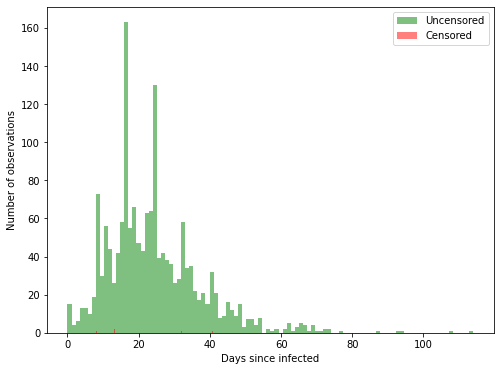

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df[df.event == 1].timeline.values, bins=100,
        color='green', alpha=0.5, lw=0, label='Uncensored');
ax.hist(df[df.event == 0].timeline.values, bins=100,
        color='red', alpha=0.5, lw=0, label='Censored');
ax.set_xlabel('Days since infected');
ax.set_ylabel('Number of observations');
ax.legend();

In [16]:
# from lifelines.plotting import plot_lifetimes
# CURRENT_TIME = df["timeline"].max()
# actual_lifetimes = df["timeline"].values
# observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
# death_observed = actual_lifetimes < CURRENT_TIME
# ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
# ax.set_xlabel("Timeline")
# ax.set_title("Infected dudation of our population")

# Kaplan-Meier Estimate

Text(0.5, 1.0, ' KaplanMeier: Survival function')

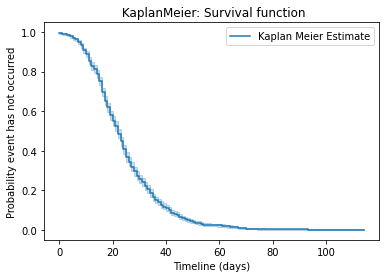

In [17]:
from lifelines import KaplanMeierFitter

df_km = df.copy()

# Create a kmf object
kmf = KaplanMeierFitter() 

# Fit the data into the model
durations = df_km["timeline"].values
event_observed = df_km["event"].values
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

# Create an estimate
kmf.plot(ci_show=True) # ci = confidence interval
plt.xlabel("Timeline (days)")
plt.ylabel("Probability event has not occurred")
plt.title(" KaplanMeier: Survival function")

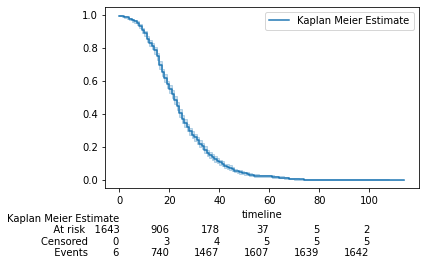

In [18]:
kmf.plot(at_risk_counts=True)

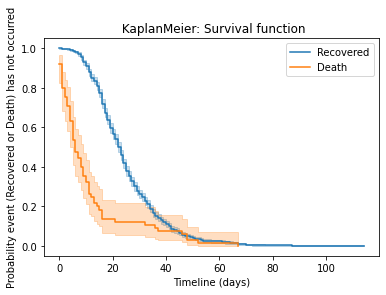

In [19]:
ax = plt.subplot(111)
kmf.fit(df_km[df_km["death"]==0]["timeline"].values, df_km[df_km["death"]==0]["event"].values,label='Recovered')
kmf.plot(ax=ax) 
kmf.fit(df_km[df_km["death"]==1]["timeline"].values, df_km[df_km["death"]==1]["event"].values,label='Death')
kmf.plot(ax=ax)
plt.xlabel("Timeline (days)")
plt.ylabel("Probability event (Recovered or Death) has not occurred")
plt.title(" KaplanMeier: Survival function");

# Cox Proportional Hazard Model

In [20]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import LabelEncoder

df_cox = df.copy()
print (df_cox.columns)
df_cox = df_cox.drop(columns=["index","confirmed_date","released_date","deceased_date","death","state"], axis=1)
df_cox = df_cox.dropna()
# df_dummy = pd.get_dummies(df_cox, drop_first=True)
# df_dummy = df_dummy.dropna()
# df_dummy.head(2)

df_cox.head()

Index(['index', 'sex', 'age', 'confirmed_date', 'released_date',
       'deceased_date', 'state', 'timeline', 'event', 'death'],
      dtype='object')


,sex,age,timeline,event
0,male,50s,13.0,1
1,male,30s,32.0,1
2,male,50s,20.0,1
3,male,20s,16.0,1
4,female,20s,24.0,1


In [21]:
# encode string data
le = LabelEncoder()
le.fit_transform(df_cox[['sex']].values)
sex_dict = dict(zip(le.classes_, le.transform(le.classes_)))
print(sex_dict)
le.fit_transform(df_cox[['age']].values)
age_dict = dict(zip(le.classes_, le.transform(le.classes_)))
print(age_dict)

df_encode = df_cox[['sex', 'age']].apply(le.fit_transform)
df_cox = pd.concat([df_cox[["timeline","event"]], df_encode], axis=1)
df_cox.head()

{'female': 0, 'male': 1}
{'0s': 0, '100s': 1, '10s': 2, '20s': 3, '30s': 4, '40s': 5, '50s': 6, '60s': 7, '70s': 8, '80s': 9, '90s': 10}


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,timeline,event,sex,age
0,13.0,1,1,6
1,32.0,1,1,4
2,20.0,1,1,6
3,16.0,1,1,3
4,24.0,1,0,3


In [22]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='timeline', event_col='event')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 1638 total observations, 5 right-censored observations>
             duration col = 'timeline'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1638
number of events observed = 1633
   partial log-likelihood = -10445.37
         time fit was run = 2020-10-04 01:23:23 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.04       0.97       0.05            -0.13             0.06                 0.87                 1.06
age        -0.06       0.94       0.01            -0.08            -0.03                 0.92                 0.97

              z      p   -log2(p)
covariate                        
sex       -0.71   0.48       1.06
age       -4.83 <0.005      19.50
---
Concordance = 0.53
Partial AIC = 20894.74
log-likelihood ratio test = 23.51 on 2 df
-log2(p) of ll-ratio test = 16.96

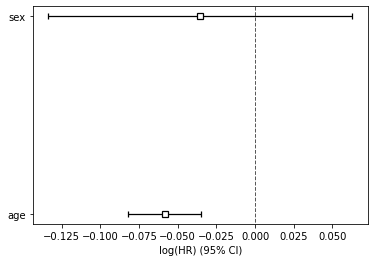

In [23]:
cph.plot()

Text(0.5, 1.0, 'Cox: Individual survival')

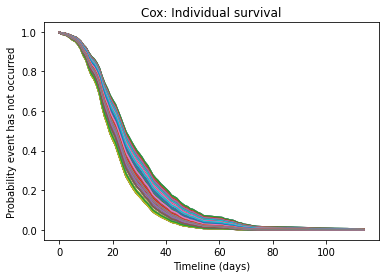

In [24]:
cph.predict_survival_function(df_cox).plot(legend=None)
plt.xlabel("Timeline (days)")
plt.ylabel("Probability event has not occurred")
plt.title("Cox: Individual survival")


Text(0.5, 1.0, 'Cox: survival analysis by age')

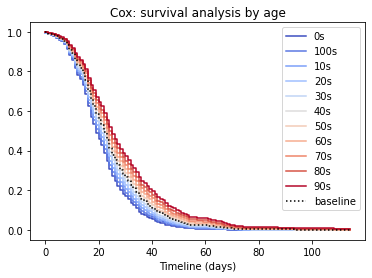

In [25]:
cph.plot_partial_effects_on_outcome(covariates="age", values=list(age_dict.values()), cmap='coolwarm')
# plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
age_dict_list_baseline = list(age_dict.keys()) + ["baseline"]
plt.legend(labels=age_dict_list_baseline)

plt.xlabel("Timeline (days)")
# plt.ylabel("Probability event has not occurred")
plt.title("Cox: survival analysis by age")

Text(0.5, 1.0, 'Cox: survival analysis by age')

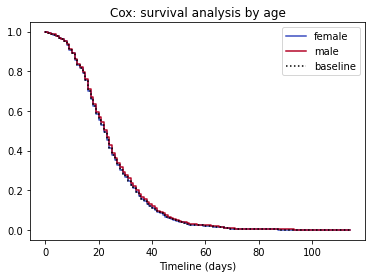

In [26]:
cph.plot_partial_effects_on_outcome(covariates="sex", values=list(sex_dict.values()), cmap='coolwarm')
sex_dict_list_baseline = list(sex_dict.keys()) + ["baseline"]
plt.legend(labels=sex_dict_list_baseline)

plt.xlabel("Timeline (days)")
# plt.ylabel("Probability event has not occurred")
plt.title("Cox: survival analysis by age")

### prediction

In [27]:
age_dict

{'0s': 0,
 '100s': 1,
 '10s': 2,
 '20s': 3,
 '30s': 4,
 '40s': 5,
 '50s': 6,
 '60s': 7,
 '70s': 8,
 '80s': 9,
 '90s': 10}

Text(0.5, 1.0, 'Prediction of survival probabilities using selected cases')

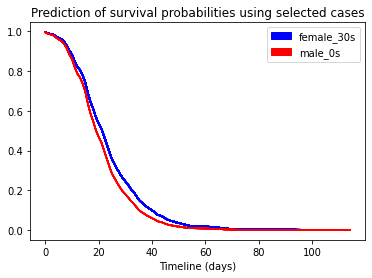

In [28]:
import matplotlib.patches as mpatches
# predict specific case 
case1 = df_cox.loc[(df_cox['sex']==0) & ((df_cox['age']==4))]
case2 = df_cox.loc[(df_cox['sex']==1) & ((df_cox['age']==0))]
# case3 = df_cox.loc[(df_cox['sex']==0) & ((df_cox['age']==0))]

ax = plt.subplot(1,1,1)
cph.predict_survival_function(case1).plot(ax=ax, color="blue", legend=None)
blue_patch = mpatches.Patch(color='blue', label='female_30s')
cph.predict_survival_function(case2).plot(ax=ax, color="red", legend=None)
red_patch = mpatches.Patch(color='red', label='male_0s')
plt.legend(handles=[blue_patch, red_patch])

plt.xlabel("Timeline (days)")
plt.title("Prediction of survival probabilities using selected cases")

In [29]:
96# # predict specific case
# ix = (df_dummy['sex_male']==0) & ((df_dummy['age_30s']==1))
# case1 = df_dummy.loc[ix]
# ix = (df_dummy['sex_male']==0) & ((df_dummy['age_100s']==1))
# case2 = df_dummy.loc[ix]

# ax = plt.subplot(2,1,1)
# cph.predict_cumulative_hazard(case1).plot(ax=ax, legend=None)
# cph.predict_cumulative_hazard(case2).plot(ax=ax, legend="case2")

# ax = plt.subplot(2,1,2)
# cph.predict_survival_function(case1).plot(ax=ax, legend=None)
# cph.predict_survival_function(case2).plot(ax=ax, legend=None)

96

# Bayesian proportional hazard model

In [30]:
# try only 1000 samples due to memory problems (to be fixed)
dfb = process_data(df_patient.head(1000))
n_patients = dfb.shape[0]
patients = np.arange(n_patients)
print (n_patients)
print (dfb.event.mean())

time min:3.0, max:32.0
54
1.0


In [31]:
SEED = 644567 # from random.org
n_samples = 5000
n_tune = 1000

In [32]:
interval_length = 3
interval_bounds = np.arange(0, dfb.timeline.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [33]:
last_period = np.floor((dfb.timeline - 0.01) / interval_length).astype(int)
death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = dfb.event
exposure = np.greater_equal.outer(dfb.timeline.values, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = dfb.timeline - interval_bounds[last_period]
len(exposure)

54

In [34]:
with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    beta = pm.Normal('beta', 0, sigma=1000)

    # lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta), lambda0))
    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * dfb.death), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

    trace = pm.sample(n_samples, tune=n_tune, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [beta, lambda0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 18 seconds.
There were 3330 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8135 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [35]:
np.exp(trace['beta'].mean())

6.969345670451419e-06

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


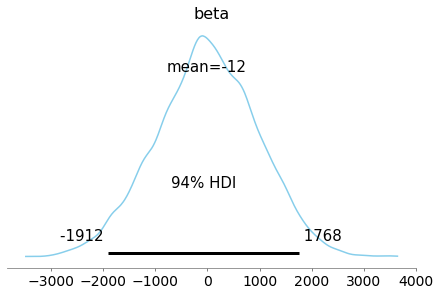

In [36]:
pm.plot_posterior(trace, var_names=['beta'], color='#87ceeb');

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


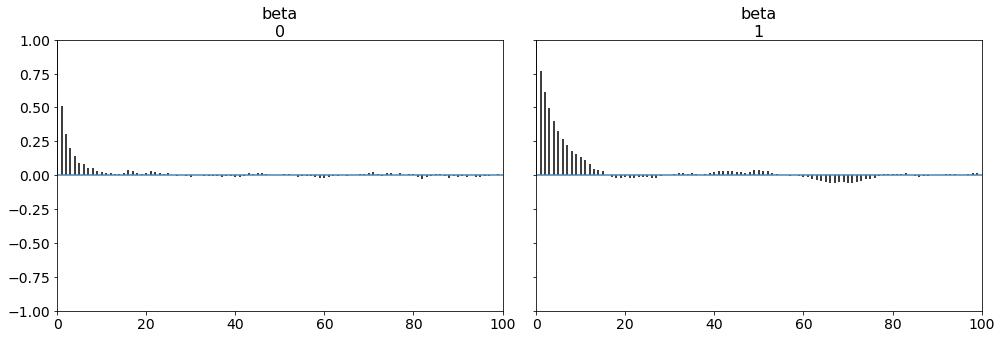

In [37]:
pm.autocorrplot(trace, var_names=['beta']);

In [38]:
base_hazard = trace['lambda0']
death_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [39]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [40]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

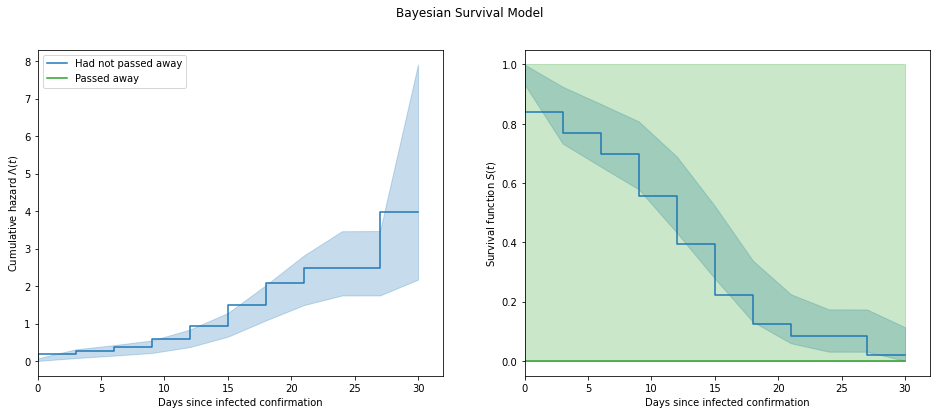

In [41]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard, hazard_ax, color=blue, label='Had not passed away')
plot_with_hpd(interval_bounds[:-1], death_hazard, cum_hazard, hazard_ax, color=red, label='Passed away')

hazard_ax.set_xlim(0, dfb.timeline.max());
hazard_ax.set_xlabel('Days since infected confirmation');
hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');
hazard_ax.legend(loc=2);
plot_with_hpd(interval_bounds[:-1], base_hazard, survival, surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], death_hazard, survival, surv_ax, color=red)
surv_ax.set_xlim(0, dfb.timeline.max());
surv_ax.set_xlabel('Days since infected confirmation');
surv_ax.set_ylabel('Survival function $S(t)$');
fig.suptitle('Bayesian Survival Model');